# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

---
The dataset represents **17 marketing campaigns** that took place between May 2008 and November 2010.


"The dataset collected is related to 17 campaigns that
occurred between May 2008 and November 2010,
corresponding to a total of 79354 contacts. During these
phone campaigns, an attractive long-term deposit
application, with good interest rates, was offered. For each
contact, a large number of attributes was stored (e.g. see
Table 2) and if there was a success (the target variable).
For the whole database considered, there were 6499
successes (8% success rate)." ~ Materials and Methods section of CRISP-DM-BANK.pdf

---

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [364]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, classification_report,ConfusionMatrixDisplay, confusion_matrix
from tabulate import tabulate
import os

In [126]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [128]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [130]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

---
#### Feature Understanding:
- There are **no missing values** in the dataset (`non-null` count is 41,188 for all columns).
- The following columns should be **converted to the `category` data type** to better reflect their nature and improve efficiency:
  -  'job', 'marital', 'education', 'default', 'housing','loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'
    
---


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

---
#### Business Objective

The primary objective of this project is to help a bank run smarter, more efficient marketing campaigns by using data to predict which customers are most likely to say yes to a special savings product called a term deposit. In the past, these campaigns had low success rates—only about 8%—which led to wasted time, high costs, and customer frustration. By applying data mining and machine learning techniques, we’re building a classification model that analyzes past campaign data to identify high-potential customers to call. This targeted approach reduces unnecessary outreach, saves valuable resources like call center time, improves customer satisfaction, and boosts the overall return on investment. 

---

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [140]:
# List of columns to convert to category dtype
categorical_columns = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'
]

# Convert each column to 'category'
for col in categorical_columns:
    df[col] = df[col].astype('category')


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   default         41188 non-null  category
 5   housing         41188 non-null  category
 6   loan            41188 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  int64   
 11  campaign        41188 non-null  int64   
 12  pdays           41188 non-null  int64   
 13  previous        41188 non-null  int64   
 14  poutcome        41188 non-null  category
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

In [144]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [146]:
print("\nDescriptive Statistics of Categorical Variables")
df.describe(include=['object', 'category'])


Descriptive Statistics of Categorical Variables


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


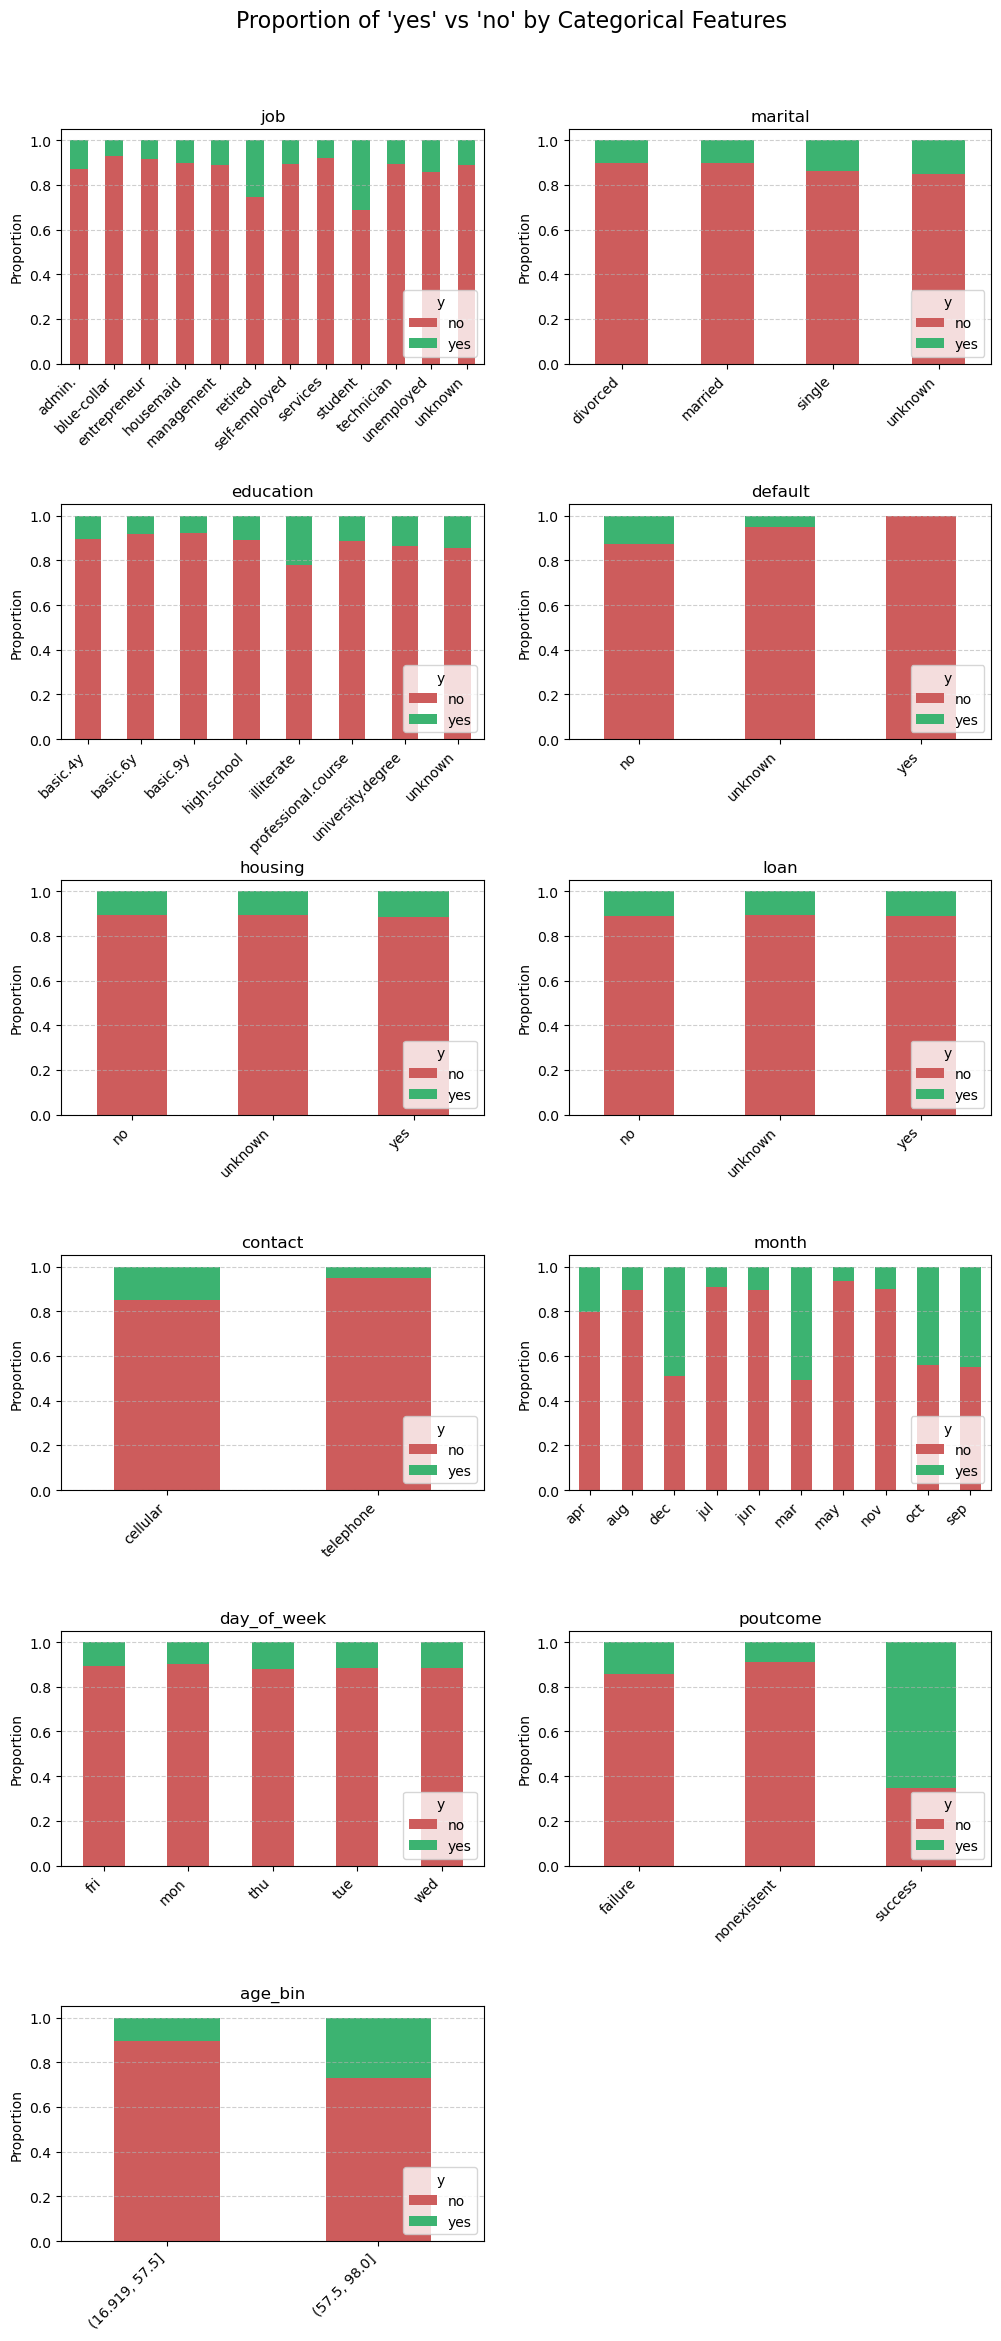

In [382]:
# Get categorical columns (excluding the target itself)
cat_cols = df.select_dtypes(include='category').columns.drop('y')

# Setup 2x6 layout
n_cols = 2
n_rows = int(np.ceil(len(cat_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

# Plot each categorical variable
for i, col in enumerate(cat_cols):
    ax = axes[i]
    crosstab = pd.crosstab(df[col], df['y'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, ax=ax, color=['indianred', 'mediumseagreen'])

    ax.set_title(f"{col}", fontsize=12)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='y', loc='lower right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Main title and layout
fig.suptitle("Proportion of 'yes' vs 'no' by Categorical Features", fontsize=16)
fig.subplots_adjust(hspace=0.6, top=0.93, bottom=0.05)

# Save and display
plt.savefig("images/categorical_features_proportion.png", bbox_inches='tight')
plt.show()

Numerical Features Correlation with y_binary (Subscription Success):
y_binary          1.000000
duration          0.405274
previous          0.230181
cons.conf.idx     0.054878
age               0.030399
campaign         -0.066357
cons.price.idx   -0.136211
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354678
Name: y_binary, dtype: float64


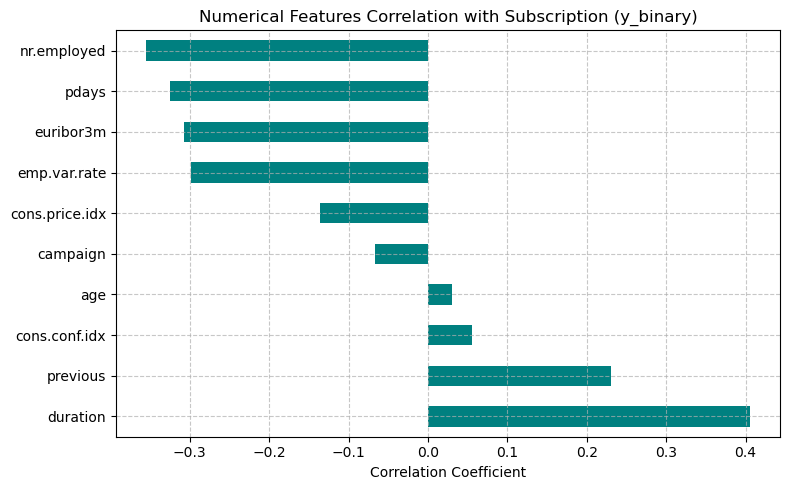

In [384]:

# List of numerical columns
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Create y_binary if not yet done
df['y_binary'] = df['y'].map({'yes': 1, 'no': 0}).astype(int)

# Correlation of numerical features with y_binary
numerical_correlation = df[numerical_cols + ['y_binary']].corr()['y_binary'].sort_values(ascending=False)

print("Numerical Features Correlation with y_binary (Subscription Success):")
print(numerical_correlation)

# Visualize
plt.figure(figsize=(8, 5))
numerical_correlation.drop('y_binary', errors='ignore').plot(kind='barh', color='teal')
plt.title('Numerical Features Correlation with Subscription (y_binary)')
plt.xlabel('Correlation Coefficient')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save to file
plt.savefig('images/numerical_features_correlation.png', bbox_inches='tight')

# Show plot
plt.show()



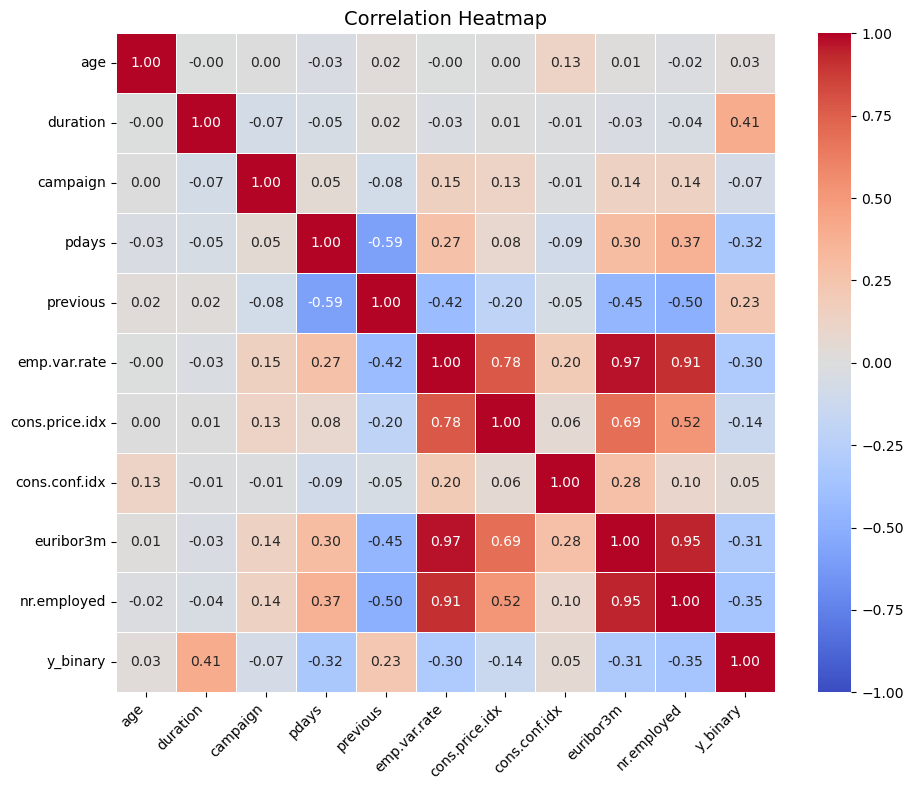

In [152]:
# Selecting numerical features only
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Heatmap on numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_numeric.corr(),
    annot=True,
    fmt=".2f",                 # Rounded to 2 decimal places
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5,            # Add gridlines
    linecolor='white',
    square=True                # Keep squares for symmetry
)
plt.title('Correlation Heatmap', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()





#### Explore Categorical Client info

In [155]:
# Select only object type columns
object_cols = df.select_dtypes(include=['category']).drop(columns=['y'], errors='ignore')

# Filter categorical columns that have less than 15 unique values
filtered_cols = [col for col in object_cols.columns if df[col].nunique() < 15]

# Create a dictionary to store unique values, counts, null counts, and null percentage
unique_values_counts = {
    col: {
        "unique_values": df[col].value_counts().to_dict(),
        "null_count": df[col].isnull().sum(),
        "null_percentage": (df[col].isnull().sum() / len(df)) * 100
    }
    for col in filtered_cols
}

# Display the results
for col, data in unique_values_counts.items():
    print(f"Column: {col}")
    print(f"Null Count: {data['null_count']}")
    print(f"Null Percentage: {data['null_percentage']:.2f}%")
    print("Unique Values and Counts:")
    for value, count in data["unique_values"].items():
        print(f"  {value}: {count}")
    print("-" * 40)

Column: job
Null Count: 0
Null Percentage: 0.00%
Unique Values and Counts:
  admin.: 10422
  blue-collar: 9254
  technician: 6743
  services: 3969
  management: 2924
  retired: 1720
  entrepreneur: 1456
  self-employed: 1421
  housemaid: 1060
  unemployed: 1014
  student: 875
  unknown: 330
----------------------------------------
Column: marital
Null Count: 0
Null Percentage: 0.00%
Unique Values and Counts:
  married: 24928
  single: 11568
  divorced: 4612
  unknown: 80
----------------------------------------
Column: education
Null Count: 0
Null Percentage: 0.00%
Unique Values and Counts:
  university.degree: 12168
  high.school: 9515
  basic.9y: 6045
  professional.course: 5243
  basic.4y: 4176
  basic.6y: 2292
  unknown: 1731
  illiterate: 18
----------------------------------------
Column: default
Null Count: 0
Null Percentage: 0.00%
Unique Values and Counts:
  no: 32588
  unknown: 8597
  yes: 3
----------------------------------------
Column: housing
Null Count: 0
Null Percentage

#### Explore Macro Economic Features

In [158]:
macro_features = [
    'emp.var.rate',        # employment variation rate
    'cons.price.idx',      # consumer price index
    'cons.conf.idx',       # consumer confidence index
    'euribor3m',           # euribor 3 month rate
    'nr.employed'          # number of employees
]

# Create a new DataFrame with just these features
df_macro = df[macro_features].copy()

# Count the unique permutations of the macroeconomic feature combinations
macro_combinations = df_macro.groupby([
    'emp.var.rate', 
    'cons.price.idx', 
    'cons.conf.idx', 
    'euribor3m', 
    'nr.employed'
]).size().reset_index(name='count')

# Sort by count descending
macro_combinations_sorted =macro_combinations.sort_values(by='count', ascending=False)

csv_path = "data/macro_combinations_sorted.csv"
macro_combinations_sorted.to_csv(csv_path, index=False)

csv_path

'data/macro_combinations_sorted.csv'

In [160]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[macro_features])

# Fit KMeans with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
df_macro['macro_cluster'] = kmeans.fit_predict(X_scaled)

# Get inverse-transformed cluster centers
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=macro_features
)
cluster_centers['cluster'] = cluster_centers.index

# Compute pairwise distances between cluster centers
distances = pd.DataFrame(
    squareform(pdist(cluster_centers[macro_features])),
    columns=[f'C{i}' for i in range(10)],
    index=[f'C{i}' for i in range(10)]
)
distances

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
C0,0.000000,151.795026,37.407444,185.023675,32.188761,128.927613,6.604782,234.853274,1.064585,264.418034
C1,151.795026,0.000000,115.014874,34.453207,119.619751,23.645101,152.079461,83.139088,152.015961,113.002738
C2,37.407444,115.014874,0.000000,147.878671,7.518460,92.580949,37.106657,197.943278,37.495164,227.850437
C3,185.023675,34.453207,147.878671,0.000000,152.888253,58.059705,184.925021,50.868613,185.196808,82.204110
C4,32.188761,119.619751,7.518460,152.888253,0.000000,96.810247,32.933396,202.696040,32.423726,232.311787
C5,128.927613,23.645101,92.580949,58.059705,96.810247,0.000000,129.516662,106.327617,129.187281,135.556190
C6,6.604782,152.079461,37.106657,184.925021,32.933396,129.516662,0.000000,235.040964,5.790815,264.909132
C7,234.853274,83.139088,197.943278,50.868613,202.696040,106.327617,235.040964,0.000000,235.062972,31.876399
C8,1.064585,152.015961,37.495164,185.196808,32.423726,129.187281,5.790815,235.062972,0.000000,264.668005
C9,264.418034,113.002738,227.850437,82.204110,232.311787,135.556190,264.909132,31.876399,264.668005,0.000000


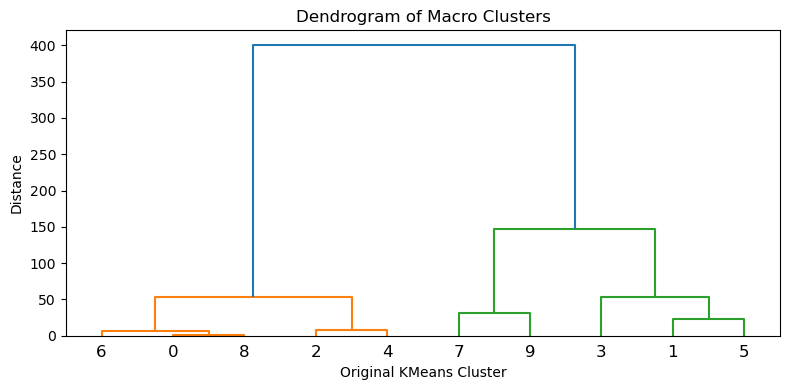

In [162]:
# Perform hierarchical clustering on the 10 cluster centers to identify merge opportunities
Z = linkage(cluster_centers[macro_features], method='ward')

# Plot dendrogram to visualize distances
plt.figure(figsize=(8, 4))
dendrogram(Z, labels=cluster_centers['cluster'].values, leaf_rotation=0)
plt.title("Dendrogram of Macro Clusters")
plt.xlabel("Original KMeans Cluster")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   default         41188 non-null  category
 5   housing         41188 non-null  category
 6   loan            41188 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  int64   
 11  campaign        41188 non-null  int64   
 12  pdays           41188 non-null  int64   
 13  previous        41188 non-null  int64   
 14  poutcome        41188 non-null  category
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

#### Feature Encoding and Clean up

In [167]:
# Start with a copy
df_model = df.copy()

### ---- 1. job ---- ###
# Group less frequent jobs into "other"
common_jobs = ['admin.', 'blue-collar', 'technician', 'services', 'management']
df_model['job'] = df_model['job'].apply(lambda x: x if x in common_jobs else 'other')

# Drop unknowns
df_model = df_model[df_model['job'] != 'unknown']

### ---- 2. marital ---- ###
df_model['marital'] = df_model['marital'].replace({
    'divorced': 'not_married',
    'single': 'not_married',
    'unknown': 'not_married'
})

### ---- 3. education (ordinal encoding) ---- ###
edu_map = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6,
    'unknown': -1  # or np.nan
}
df_model['education_level'] = df_model['education'].map(edu_map)
df_model['education_level'] = df_model['education_level'].astype(int)
df_model = df_model.drop(columns='education')

### ---- 4. Drop 'default' ---- ###
df_model = df_model.drop(columns='default')

### ---- 5. housing & loan ---- ###
# Replace 'unknown' with mode (could also use one-hot for 'unknown' explicitly)
for col in ['housing', 'loan']:
    mode = df_model[col].mode()[0]
    df_model[col] = df_model[col].replace('unknown', mode)

### ---- 6. Drop contact ---- ###
df_model = df_model.drop(columns='contact')

### ---- 7. month (ordinal or cyclical encoding) ---- ###
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df_model['month_num'] = df_model['month'].apply(lambda x: month_order.index(x) + 1)
df_model['month_num'] = df_model['month_num'].astype(int)
df_model = df_model.drop(columns='month')

### ---- 8. Drop day_of_week ---- ###
df_model = df_model.drop(columns='day_of_week')

# ---- 9. poutcome (known success vs. not) ---- #
df_model['poutcome_known_success'] = df_model['poutcome'].apply(lambda x: 1 if x == 'success' else 0)


### ---- 10. One-hot remaining categorical columns ---- ###
df_model = pd.get_dummies(df_model, columns=['job', 'marital', 'housing', 'loan'], drop_first=True)

# ---- 11. Create binary feature: was_previously_contacted (from pdays)
df_model['was_previously_contacted'] = (df_model['pdays'] != 999).astype(int)
# Replace pdays=999 with NaN or a sentinel value (optional)
df_model['pdays'] = df_model['pdays'].replace(999, -1)  # or np.nan

# ---- 12. Create binary target variable (y = 'yes' → 1, 'no' → 0)
df_model['y_binary'] = df_model['y'].map({'yes': 1, 'no': 0}).astype(int)


### ---- Final cleanup: drop unused or redundant features ---- ###
# You might want to drop: duration (leaks target), and others already engineered
df_model = df_model.drop(columns=['duration','y','poutcome'])

# View sample
df_model.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_binary,...,poutcome_known_success,job_blue-collar,job_management,job_other,job_services,job_technician,marital_married,housing_yes,loan_yes,was_previously_contacted
0,56,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,False,False,True,False,False,True,False,False,0
1,57,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,False,False,False,True,False,True,False,False,0
2,37,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,False,False,False,True,False,True,True,False,0
3,40,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,False,False,False,False,False,True,False,False,0
4,56,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,False,False,False,True,False,True,False,True,0


In [169]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       41188 non-null  int64  
 1   campaign                  41188 non-null  int64  
 2   pdays                     41188 non-null  int64  
 3   previous                  41188 non-null  int64  
 4   emp.var.rate              41188 non-null  float64
 5   cons.price.idx            41188 non-null  float64
 6   cons.conf.idx             41188 non-null  float64
 7   euribor3m                 41188 non-null  float64
 8   nr.employed               41188 non-null  float64
 9   y_binary                  41188 non-null  int64  
 10  education_level           41188 non-null  int64  
 11  month_num                 41188 non-null  int64  
 12  poutcome_known_success    41188 non-null  int64  
 13  job_blue-collar           41188 non-null  bool   
 14  job_ma

#### Identify which features will need to be scaled 

In [172]:
# Step 1: List of all feature columns (excluding target)
feature_cols = df_model.drop(columns='y_binary').columns

# Step 2: Identify binary or one-hot columns (0/1 only)
binary_cols = [
    col for col in feature_cols 
    if df_model[col].dropna().nunique() <= 2 and df_model[col].dtype in [int, bool]
]

# Step 3: Remaining numeric columns (eligible for scaling)
scale_cols = [
    col for col in feature_cols
    if df_model[col].dtype in ['int64', 'float64']
    and col not in binary_cols
]

# Step 4: Just for reference
print("Columns to SCALE:")
print(scale_cols)

print("\nColumns to NOT scale (binary/dummy):")
print(binary_cols)


Columns to SCALE:
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'education_level', 'month_num']

Columns to NOT scale (binary/dummy):
['poutcome_known_success', 'job_blue-collar', 'job_management', 'job_other', 'job_services', 'job_technician', 'marital_married', 'housing_yes', 'loan_yes', 'was_previously_contacted']


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [175]:
# Separate features and target
X = df_model.drop(columns=['y_binary'])  
y = df_model['y_binary']

# Train-test split (stratify ensures balanced classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


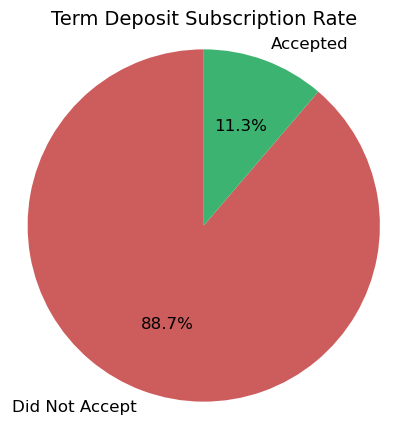

In [360]:
# Check the distribution of the target variable
# Value counts
y_counts = df['y'].value_counts(normalize=True)

# Labels and values
labels = ['Did Not Accept', 'Accepted']
sizes = [y_counts['no'], y_counts['yes']]
colors = ['indianred', 'mediumseagreen']

print(y_counts)

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Term Deposit Subscription Rate', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.

# Save to images folder
plt.savefig('images/term_deposit_subscription_pie.png', bbox_inches='tight')
plt.show()




A model that always predicts `'no'` achieves 88% accuracy but 0% recall — it completely misses the clients we actually want to find. A random model would have precision and recall around 12% (matching the class distribution), and an ROC AUC near 0.50.

To be better than random guessing in a meaningful way, we set the bar higher. We would consider **ROC AUC > 0.70** and **recall > 0.30 for the `'yes'` class** as indicators of a model that's learning useful patterns and capturing a meaningful share of positive cases.

---


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [187]:
# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scale_cols),        # Scale only selected numeric columns
        ('passthrough', 'passthrough', binary_cols)   # Leave binary/dummy columns as-is
    ]
)

# Build pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit model
logreg_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

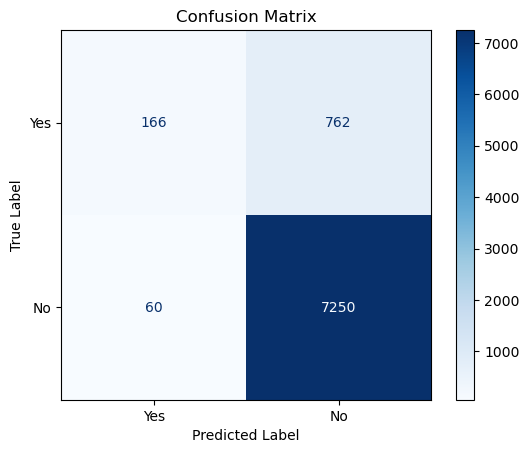

In [189]:


# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # [positive, negative]

# Display with labels focusing on "yes" (1) as the positive class
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Problem 9: Score the Model

What is the accuracy of your model?

In [192]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\n🧾 Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9002184996358339
ROC AUC: 0.7769558705599321

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      7310
           1       0.73      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.82      0.59      0.62      8238
weighted avg       0.89      0.90      0.87      8238



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [195]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

# Store results
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    start_time = time.time()
    pipeline.fit(X_train, y_train)
    end_time = time.time()

    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Train Time (s)': round(end_time - start_time, 4),
        'Recall (yes)': round(recall_score(y_test, y_pred), 4),
        'ROC AUC': round(roc_auc_score(y_test, y_proba), 4)
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

                    Model  Train Time (s)  Recall (yes)  ROC AUC
0     Logistic Regression          0.0979        0.1789   0.7770
1     K-Nearest Neighbors          0.0256        0.2769   0.7193
2           Decision Tree          0.0973        0.3265   0.6204
3  Support Vector Machine         63.3919        0.2037   0.6788


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

More feature engineering and exploration. For example, should we keep the gender feature? Why or why not?

Going back the originanl EDA, basic plots of category fields vs y column, there are some categories that we could likely drop as there does not seem to be significant difference in outcome. As example, `housing` and `loan` categories show no meaningful distinction similar to what the researchers saw with gender which they dropped.  Additionally, the coefficient plots shows `campaign`, `age`, and `cons.conf.idx` have very small coefficients relative to other columns.  Either drop or re-engineer.

In [200]:
### Review coefficents from baseline logisitic regression model

# Define feature names from your training data
feature_names = X_train.columns

# Define and fit the pipeline
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipe.fit(X_train, y_train)

# Extract coefficients
coefficients = logreg_pipe.named_steps['model'].coef_[0]

# Create DataFrame of feature importances
logreg_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Display the top features
logreg_importance_df.head(30)


,Feature,Coefficient
4,emp.var.rate,-0.639659
5,cons.price.idx,0.363174
20,was_previously_contacted,0.275089
7,euribor3m,-0.221886
8,nr.employed,-0.214562
12,job_blue-collar,-0.139329
1,campaign,-0.135652
3,previous,-0.126680
6,cons.conf.idx,0.110763
15,job_services,-0.084184


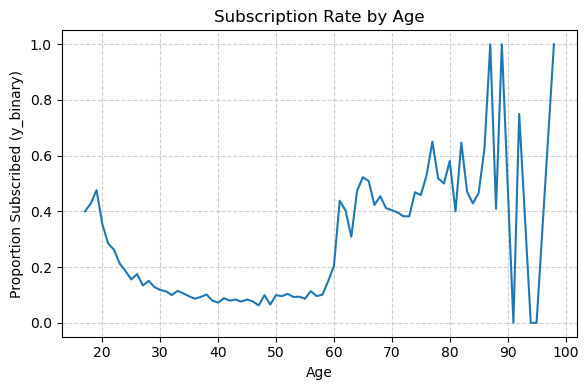

In [201]:
#go back and look at age
# Group by age and compute mean success rate
age_success = df.groupby('age')['y_binary'].mean()

# Plot
plt.figure(figsize=(6, 4))
age_success.plot()
plt.title('Subscription Rate by Age')
plt.xlabel('Age')
plt.ylabel('Proportion Subscribed (y_binary)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

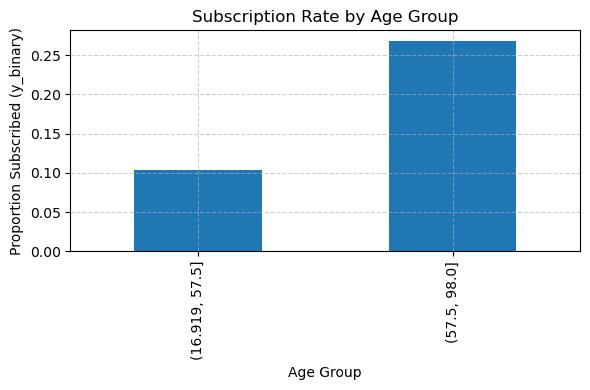

In [202]:

# Create age bins
df['age_bin'] = pd.cut(df['age'], bins=2)

# Plot average y_binary per age bin
bin_success = df.groupby('age_bin')['y_binary'].mean()

# Plot
plt.figure(figsize=(6, 4))
bin_success.plot(kind='bar')
plt.title('Subscription Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion Subscribed (y_binary)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


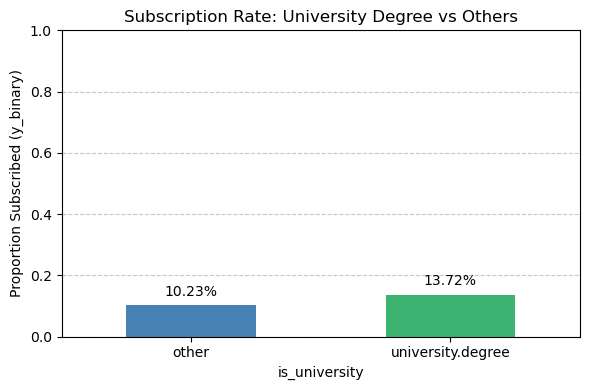

In [203]:
# Create binary feature
df['is_university'] = df['education'].apply(lambda x: 'university.degree' if x == 'university.degree' else 'other')

# Compute average subscription rate
edu_success = df.groupby('is_university')['y_binary'].mean()

# Plot
plt.figure(figsize=(6, 4))
bars = edu_success.plot(kind='bar', color=['steelblue', 'mediumseagreen'])

plt.title('Subscription Rate: University Degree vs Others')
plt.ylabel('Proportion Subscribed (y_binary)')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels
for index, value in enumerate(edu_success):
    plt.text(index, value + 0.02, f"{value:.2%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Updated Feature Engineering

In [210]:
# Start with a copy TO CREATE A NEW df_model2
df_model2 = df.copy()

### ---- 1. UPDATE: DROP job ---- no meaningful difference in success rate SEEMS MORE RELATED TO AGE ###
# Group less frequent jobs into "other"
# common_jobs = ['admin.', 'blue-collar', 'technician', 'services', 'management']
# df_model['job'] = df_model['job'].apply(lambda x: x if x in common_jobs else 'other')

# Drop unknowns
# df_model = df_model[df_model['job'] != 'unknown']
df_model2 = df_model2.drop(columns='job')

# ----UPDATE: CREATE BOOL FOR AGE is_60yo+
# Create Boolean indicator for age 60 or older
df_model2['is_60yo_plus'] = df_model2['age'] >= 60

df_model2 = df_model2.drop(columns='age')


### ---- 2. UPDATE: DROP marital ---- no meaningful differenxe in success rate###
# df_model['marital'] = df_model['marital'].replace({
#     'divorced': 'not_married',
#     'single': 'not_married',
#     'unknown': 'not_married'
# })
df_model2 = df_model2.drop(columns='marital')

### ---- 3. UPDATE: CHANGE education (ordinal encoding) ---- university.degree vs not ###
# edu_map = {
#     'illiterate': 0,
#     'basic.4y': 1,
#     'basic.6y': 2,
#     'basic.9y': 3,
#     'high.school': 4,
#     'professional.course': 5,
#     'university.degree': 6,
#     'unknown': -1  # or np.nan
# }
# df_model['education_level'] = df_model['education'].map(edu_map)
# df_model['education_level'] = df_model['education_level'].astype(int)
# df_model = df_model.drop(columns='education')
# Create binary indicator: 1 = university.degree, 0 = all others
df_model2['is_university_degree'] = (df_model2['education'] == 'university.degree').astype(bool)


# Drop original education column
df_model2 = df_model2.drop(columns='education')


### ---- 4. Drop 'default' ---- ###
df_model2 = df_model2.drop(columns='default')

### ---- 5. UPDATE:  DROP housing & loan ---- no meaningful difference in success rate###
# Replace 'unknown' with mode (could also use one-hot for 'unknown' explicitly)
# for col in ['housing', 'loan']:
#     mode = df_model[col].mode()[0]
#     df_model[col] = df_model[col].replace('unknown', mode)
df_model2 = df_model2.drop(columns=['housing','loan'])


### ---- 6. Drop contact ---- ###
df_model2 = df_model2.drop(columns='contact')

### ---- 7. month (ordinal or cyclical encoding) ---- ###
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df_model2['month_num'] = df_model2['month'].apply(lambda x: month_order.index(x) + 1)
df_model2['month_num'] = df_model2['month_num'].astype(int)
df_model2 = df_model2.drop(columns='month')

### ---- 8. Drop day_of_week ---- ###
df_model2 = df_model2.drop(columns='day_of_week')

# ---- 9. UPDATE TO HANDLE AS BOOL SO IT DOES NOT GET SCALED poutcome (known success vs. not) ---- #
# df_model['poutcome_known_success'] = df_model['poutcome'].apply(lambda x: 1 if x == 'success' else 0)
df_model2['poutcome_known_success'] = df_model2['poutcome'] == 'success'


### ---- 10. UPDATE: UNNECESSARY TO ONE HOT ENCODE AS WE DROPPED ALL THESE  remaining categorical columns ---- ###
# df_model = pd.get_dummies(df_model, columns=['job', 'marital', 'housing', 'loan'], drop_first=True)

# ---- 11. UPDATE: TO BOOL  feature: was_previously_contacted (from pdays)
# df_model['was_previously_contacted'] = (df_model['pdays'] != 999).astype(int)
df_model2['was_previously_contacted'] = df_model2['pdays'] != 999

# Replace pdays=999 with NaN or a sentinel value (optional)
df_model2['pdays'] = df_model2['pdays'].replace(999, -1)  # or np.nan


# ---- 12. UPDATE:  HANDLE AS BOOL FOR CONSISTANCY binary target variable (y = 'yes' → 1, 'no' → 0)
# df_model['y_binary'] = df_model['y'].map({'yes': 1, 'no': 0}).astype(int)
df_model2['y_binary'] = df_model2['y'] == 'yes'


### ---- Final cleanup: drop unused or redundant features ---- ###
df_model2 = df_model2.drop(columns=['duration','y','poutcome'])

In [264]:
# View sample
df_model2.sample(10)

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_binary,age_bin,is_university,is_60yo_plus,is_university_degree,month_num,poutcome_known_success,was_previously_contacted
2240,6,-1,0,1.1,93.994,-36.4,4.857,5191.0,False,"(16.919, 57.5]",university.degree,False,True,5,False,False
22664,5,-1,0,1.4,93.444,-36.1,4.964,5228.1,False,"(16.919, 57.5]",other,False,False,8,False,False
18185,2,-1,0,1.4,93.918,-42.7,4.963,5228.1,False,"(16.919, 57.5]",other,False,False,7,False,False
26777,1,-1,0,-0.1,93.200,-42.0,4.076,5195.8,False,"(16.919, 57.5]",university.degree,False,True,11,False,False
14010,2,-1,0,1.4,93.918,-42.7,4.963,5228.1,False,"(16.919, 57.5]",other,False,False,7,False,False
10473,2,-1,0,1.4,94.465,-41.8,4.961,5228.1,False,"(16.919, 57.5]",university.degree,False,True,6,False,False
10702,2,-1,0,1.4,94.465,-41.8,4.961,5228.1,False,"(16.919, 57.5]",university.degree,False,True,6,False,False
29988,1,-1,0,-1.8,93.075,-47.1,1.405,5099.1,True,"(16.919, 57.5]",university.degree,False,True,4,False,False
26904,2,-1,0,-0.1,93.200,-42.0,4.076,5195.8,False,"(16.919, 57.5]",other,False,False,11,False,False
36379,1,-1,0,-2.9,92.963,-40.8,1.262,5076.2,False,"(16.919, 57.5]",other,False,False,6,False,False


In [214]:
df_model2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   campaign                  41188 non-null  int64   
 1   pdays                     41188 non-null  int64   
 2   previous                  41188 non-null  int64   
 3   emp.var.rate              41188 non-null  float64 
 4   cons.price.idx            41188 non-null  float64 
 5   cons.conf.idx             41188 non-null  float64 
 6   euribor3m                 41188 non-null  float64 
 7   nr.employed               41188 non-null  float64 
 8   y_binary                  41188 non-null  bool    
 9   age_bin                   41188 non-null  category
 10  is_university             41188 non-null  object  
 11  is_60yo_plus              41188 non-null  bool    
 12  is_university_degree      41188 non-null  bool    
 13  month_num                 41188 non-null  int6

In [216]:
# Step 1: List of all feature columns (excluding target)
feature_cols2 = df_model2.drop(columns='y_binary').columns

# Step 2: Identify binary or one-hot columns (0/1 only)
binary_cols2 = [
    col for col in feature_cols2 
    if df_model2[col].dropna().nunique() <= 2 and df_model2[col].dtype in [int, bool]
]

# Step 3: Remaining numeric columns (eligible for scaling)
scale_cols2 = [
    col for col in feature_cols2
    if df_model2[col].dtype in ['int64', 'float64']
    and col not in binary_cols2
]

# Step 4: Just for reference
print("Columns to SCALE:")
print(scale_cols2)

print("\nColumns to NOT scale (binary/dummy):")
print(binary_cols2)

Columns to SCALE:
['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'month_num']

Columns to NOT scale (binary/dummy):
['is_60yo_plus', 'is_university_degree', 'poutcome_known_success', 'was_previously_contacted']


In [218]:
# Separate features and target
X = df_model2.drop(columns=['y_binary'])  
y = df_model2['y_binary']

# Train-test split (stratify ensures balanced classes)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [220]:
# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scale_cols2),        # Scale only selected numeric columns
        ('passthrough', 'passthrough', binary_cols2)   # Leave binary/dummy columns as-is
    ]
)


In [222]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

# Store results
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    start_time = time.time()
    pipeline.fit(X_train2, y_train2)
    end_time = time.time()

    y_pred = pipeline.predict(X_test2)
    y_proba = pipeline.predict_proba(X_test2)[:, 1]

    results.append({
        'Model': name,
        'Train Time (s)': round(end_time - start_time, 4),
        'Recall (yes)': round(recall_score(y_test2, y_pred), 4),
        'ROC AUC': round(roc_auc_score(y_test2, y_proba), 4)
    })

# Display results
results_df2 = pd.DataFrame(results)
print(results_df2)

                    Model  Train Time (s)  Recall (yes)  ROC AUC
0     Logistic Regression          0.0692        0.1843   0.7777
1     K-Nearest Neighbors          0.0125        0.3082   0.7485
2           Decision Tree          0.0296        0.2554   0.6457
3  Support Vector Machine         22.2335        0.2144   0.6786



---

###  Model Comparison: Before vs. After Feature Updates

| Model                    | Train Time (Before) | Train Time (After) | Recall (yes) Before | Recall (yes) After | ROC AUC Before | ROC AUC After |
|--------------------------|---------------------|---------------------|----------------------|---------------------|----------------|----------------|
| **Logistic Regression**  | 0.0979 s            | 0.0692 s            | 0.1789               | 0.1843              | 0.7770         | 0.7777         |
| **K–Nearest Neighbors**  | 0.0256 s            | 0.0125 s            | 0.2769               | 0.3082              | 0.7193         | 0.7485         |
| **Decision Tree**        | 0.0973 s            | 0.0296 s            | 0.3265               | 0.2554              | 0.6204         | 0.6457         |
| **Support Vector Machine** | 63.3919 s         | 22.2335 s           | 0.2037               | 0.2144              | 0.6788         | 0.6786         |

---

###  Summary

-  **Training time improved** across the board, especially for **SVM** (cut from ~63s to ~22s).
-  **KNN** saw a strong **boost in both recall and AUC**, making it a more compelling model after the updates.
-  **Logistic Regression** remained the most balanced model, with consistent and high ROC AUC and slight gains in recall.
-  **Decision Tree** recall dropped slightly, but ROC AUC improved — indicating a better tradeoff between false positives and false negatives.
-  Overall, **feature simplification and cleaning clearly improved performance and efficiency**.

---




In [225]:
# Define pipelines using the preprocessor
pipelines = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'K-Nearest Neighbors': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'Support Vector Machine': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42))
    ])
}


In [227]:
# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Support Vector Machine': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}

In [235]:
# Initialize or load existing results

results_random = []  # initialize if not defined

# ==================== CHUNK 1: Logistic Regression ====================
name = 'Logistic Regression'
pipeline = pipelines[name]

print(f"\nRunning RandomizedSearchCV for {name}...")

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grids[name],
    n_iter=10,
    scoring='recall',
    cv=5,
    n_jobs=1,
    verbose=1,
    random_state=42
)

start_time = time.time()
random_search.fit(X_train2, y_train2)
print("✔️ Finished fitting", name)

end_time = time.time()

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test2)
y_proba = best_model.predict_proba(X_test2)[:, 1]

results_random.append({
    'Model': name,
    'Train Time (s)': round(end_time - start_time, 4),
    'Recall (yes)': round(recall_score(y_test2, y_pred), 4),
    'ROC AUC': round(roc_auc_score(y_test2, y_proba), 4),
    'Best Params': random_search.best_params_
})


Running RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✔️ Finished fitting Logistic Regression


In [237]:
results_random_df = pd.DataFrame(results_random)

# Print the table with headers
print(tabulate(results_random_df, headers='keys', tablefmt='plain', showindex=False))


Model                  Train Time (s)    Recall (yes)    ROC AUC  Best Params
Logistic Regression            0.7022          0.1853     0.7778  {'classifier__C': 10}


In [239]:
# ==================== CHUNK 2: K-Nearest Neighbors ====================
# Repeat block above, replacing name = 'K-Nearest Neighbors'
name = 'K-Nearest Neighbors'
pipeline = pipelines[name]

print(f"\nRunning RandomizedSearchCV for {name}...")

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grids[name],
    n_iter=10,
    scoring='recall',
    cv=5,
    n_jobs=1,
    verbose=1,
    random_state=42
)

start_time = time.time()
random_search.fit(X_train2, y_train2)
print("✔️ Finished fitting", name)
end_time = time.time()

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test2)
y_proba = best_model.predict_proba(X_test2)[:, 1]

results_random.append({
    'Model': name,
    'Train Time (s)': round(end_time - start_time, 4),
    'Recall (yes)': round(recall_score(y_test2, y_pred), 4),
    'ROC AUC': round(roc_auc_score(y_test2, y_proba), 4),
    'Best Params': random_search.best_params_
})


Running RandomizedSearchCV for K-Nearest Neighbors...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✔️ Finished fitting K-Nearest Neighbors


In [241]:
results_random_df = pd.DataFrame(results_random)
print(tabulate(results_random_df, headers='keys', tablefmt='plain', showindex=False))


Model                  Train Time (s)    Recall (yes)    ROC AUC  Best Params
Logistic Regression            0.7022          0.1853     0.7778  {'classifier__C': 10}
K-Nearest Neighbors            3.7088          0.3006     0.7137  {'classifier__weights': 'uniform', 'classifier__n_neighbors': 3}


In [243]:
# ==================== CHUNK 3: Decision Tree ====================
# Repeat block above, replacing name = 'Decision Tree'
name = 'Decision Tree'
pipeline = pipelines[name]

print(f"\nRunning RandomizedSearchCV for {name}...")

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grids[name],
    n_iter=10,
    scoring='recall',
    cv=5,
    n_jobs=1,
    verbose=1,
    random_state=42
)

start_time = time.time()
random_search.fit(X_train2, y_train2)
print("✔️ Finished fitting", name)
end_time = time.time()

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test2)
y_proba = best_model.predict_proba(X_test2)[:, 1]

results_random.append({
    'Model': name,
    'Train Time (s)': round(end_time - start_time, 4),
    'Recall (yes)': round(recall_score(y_test2, y_pred), 4),
    'ROC AUC': round(roc_auc_score(y_test2, y_proba), 4),
    'Best Params': random_search.best_params_
})


Running RandomizedSearchCV for Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✔️ Finished fitting Decision Tree


In [245]:
results_random_df = pd.DataFrame(results_random)
print(tabulate(results_random_df, headers='keys', tablefmt='plain', showindex=False))


Model                  Train Time (s)    Recall (yes)    ROC AUC  Best Params
Logistic Regression            0.7022          0.1853     0.7778  {'classifier__C': 10}
K-Nearest Neighbors            3.7088          0.3006     0.7137  {'classifier__weights': 'uniform', 'classifier__n_neighbors': 3}
Decision Tree                  1.0354          0.2597     0.7338  {'classifier__min_samples_split': 10, 'classifier__max_depth': None}


In [247]:
# ==================== CHUNK 4: Support Vector Machine ====================
# Repeat block above, replacing name = 'Support Vector Machine'
name = 'Support Vector Machine'
pipeline = pipelines[name]

print(f"\nRunning RandomizedSearchCV for {name}...")

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grids[name],
    n_iter=3,
    scoring='recall',
    cv=5,
    n_jobs=1,
    verbose=1,
    random_state=42
)

start_time = time.time()
random_search.fit(X_train2, y_train2)
print("✔️ Finished fitting", name)
end_time = time.time()

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test2)
y_proba = best_model.predict_proba(X_test2)[:, 1]

results_random.append({
    'Model': name,
    'Train Time (s)': round(end_time - start_time, 4),
    'Recall (yes)': round(recall_score(y_test2, y_pred), 4),
    'ROC AUC': round(roc_auc_score(y_test2, y_proba), 4),
    'Best Params': random_search.best_params_
})


Running RandomizedSearchCV for Support Vector Machine...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✔️ Finished fitting Support Vector Machine


In [105]:
# ==================== FINAL STEP: Create or Update DataFrame ====================
results_random_df = pd.DataFrame(results_random)
print(tabulate(results_random_df, headers='keys', tablefmt='plain', showindex=False))


Model                     Train Time (s)    Recall (yes)    ROC AUC  Best Params
Logistic Regression               0.7601          0.1853     0.7778  {'classifier__C': 10}
K-Nearest Neighbors               3.8303          0.3006     0.7137  {'classifier__weights': 'uniform', 'classifier__n_neighbors': 3}
Decision Tree                     1.0707          0.2597     0.7338  {'classifier__min_samples_split': 10, 'classifier__max_depth': None}
Support Vector Machine          268.667           0.2155     0.7085  {'classifier__kernel': 'rbf', 'classifier__C': 10}



---

### Model Performance Comparison: Baseline vs. Feature Engineering Updates vs. with Hyperparameter Tuning

| Model                    | Train Time Baseline | Train Time Features | Train Time w/Tuning | Recall (yes) Baseline | Recall (yes) Features | Recall (yes) w/Tuning | ROC AUC Baseline | ROC AUC Features | ROC AUC w/Tuning |
|--------------------------|------------------------|------------------------|----------------------------|------------------------|------------------------|-----------------------------|-------------------|------------------|------------------------|
| **Logistic Regression**  | 0.0979 s               | 0.0692 s               | 0.7601 s                   | 0.1789                 | 0.1843                 | 0.1853                      | 0.7770            | 0.7777           | 0.7778                 |
| **K–Nearest Neighbors**  | 0.0256 s               | 0.0125 s               | 3.8303 s                   | 0.2769                 | 0.3082                 | 0.3006                      | 0.7193            | 0.7485           | 0.7137                 |
| **Decision Tree**        | 0.0973 s               | 0.0296 s               | 1.0707 s                   | 0.3265                 | 0.2554                 | 0.2597                      | 0.6204            | 0.6457           | 0.7338                 |
| **Support Vector Machine** | 63.3919 s            | 22.2335 s              | 268.667 s                  | 0.2037                 | 0.2144                 | 0.2155                      | 0.6788            | 0.6786           | 0.7085                 |

---

### Summary

- Feature engineering significantly reduced training time and often improved both recall and ROC AUC.
- Tuning hyperparameters boosted ROC AUC for all models, especially the Decision Tree (from 0.6457 to 0.7338).
- K-Nearest Neighbors maintained the highest recall across all phases, although its AUC decreased slightly with tuning.
- Logistic Regression remained the most consistent and interpretable model, with top AUC and stable recall.
- Support Vector Machine showed modest performance gains, but incurred a significant increase in training time due to the tuning process.

---

#### Display confusion matrix for Best Models

<Figure size 500x400 with 0 Axes>

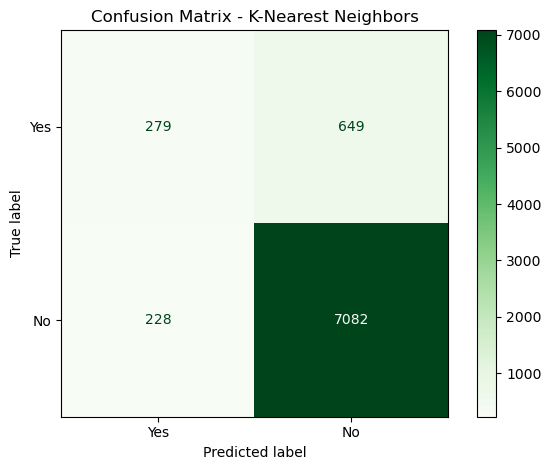

In [392]:
# Best KNN (Highest Recall and High AUC-ROC)
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(weights='uniform', n_neighbors=3))
])
knn_pipeline.fit(X_train2, y_train2)
y_pred_knn = knn_pipeline.predict(X_test2)

plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_knn, labels=[1, 0], display_labels=["Yes","No"], cmap='Greens')
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.grid(False)
plt.tight_layout()
plt.savefig("images/conf_matrix_knn.png", dpi=300)
plt.show()

<Figure size 500x400 with 0 Axes>

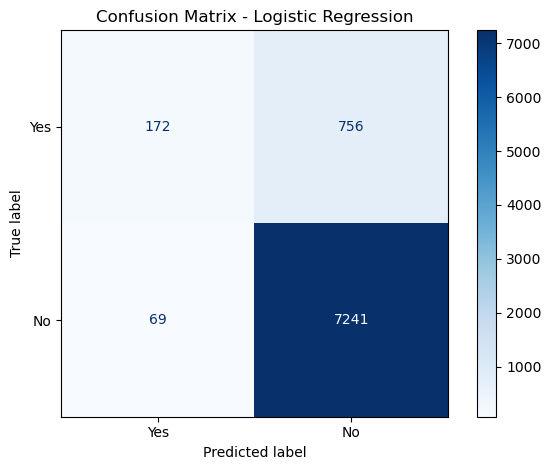

In [390]:
# Best Linear Regression (High Interpretability and Highest AUC-ROC, Recall only ok)
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=10, max_iter=1000, random_state=42))
])
logreg_pipeline.fit(X_train2, y_train2)

y_pred_logreg = logreg_pipeline.predict(X_test2)

plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_logreg, labels=[1, 0], display_labels=["Yes","No"], cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.tight_layout()
plt.savefig("images/conf_matrix_logreg.png", dpi=300)
plt.show()



Feature count: 13
Coefficient count: 13


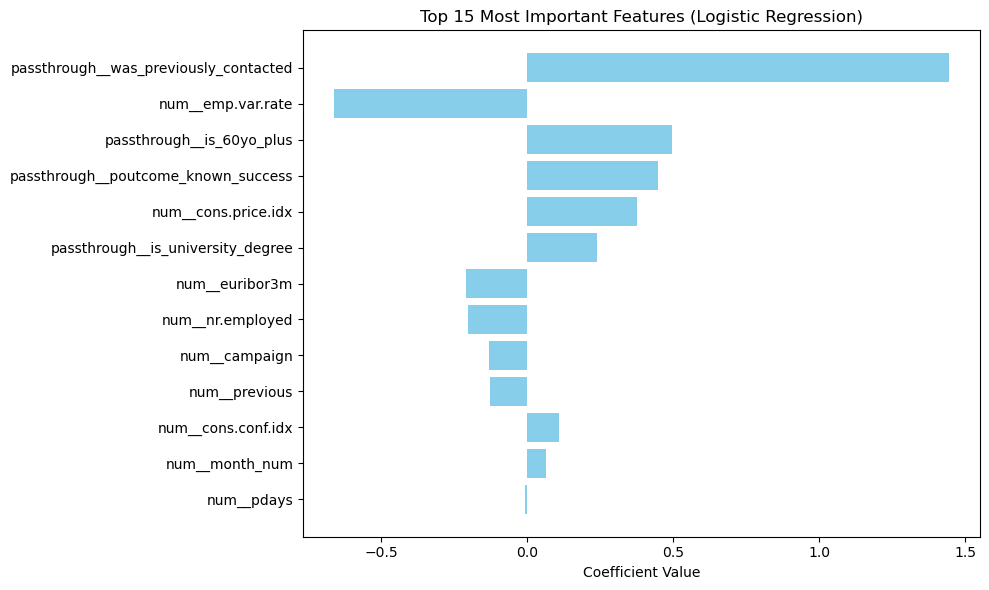

In [388]:

# Get transformed feature names from the preprocessor inside the pipeline
# Use sklearn's get_feature_names_out() method
feature_names = logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extract coefficients
coefficients = logreg_pipeline.named_steps['classifier'].coef_[0]

# Check length match before building DataFrame
print("Feature count:", len(feature_names))
print("Coefficient count:", len(coefficients))

# Build feature importance DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Plot top 15
top_features = coef_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Top 15 Most Important Features (Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig("images/logistic_top_features.png", dpi=300)


plt.show()


<Figure size 500x400 with 0 Axes>

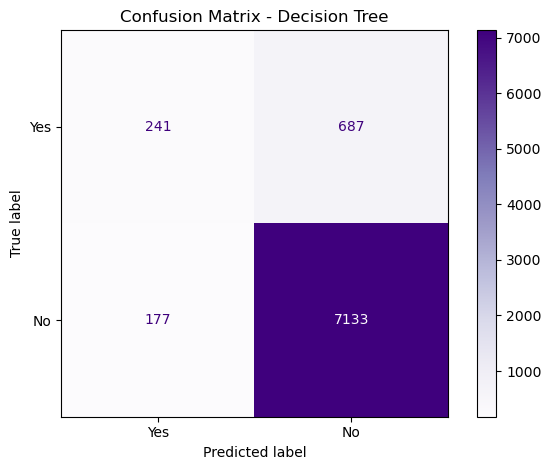

In [386]:
from sklearn.tree import plot_tree

DecisionTreeClassifier(min_samples_split=10, max_depth=None, random_state=42)

 #from sklearn.tree import DecisionTreeClassifier

tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(min_samples_split=10, max_depth=None, random_state=42))
])
tree_pipeline.fit(X_train2, y_train2)

y_pred_tree = tree_pipeline.predict(X_test2)

plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_tree, labels=[1, 0], display_labels=["Yes","No"], cmap='Purples')
plt.title("Confusion Matrix - Decision Tree")
plt.grid(False)
plt.tight_layout()
plt.savefig("images/conf_matrix_dtree.png", dpi=300)
plt.show()

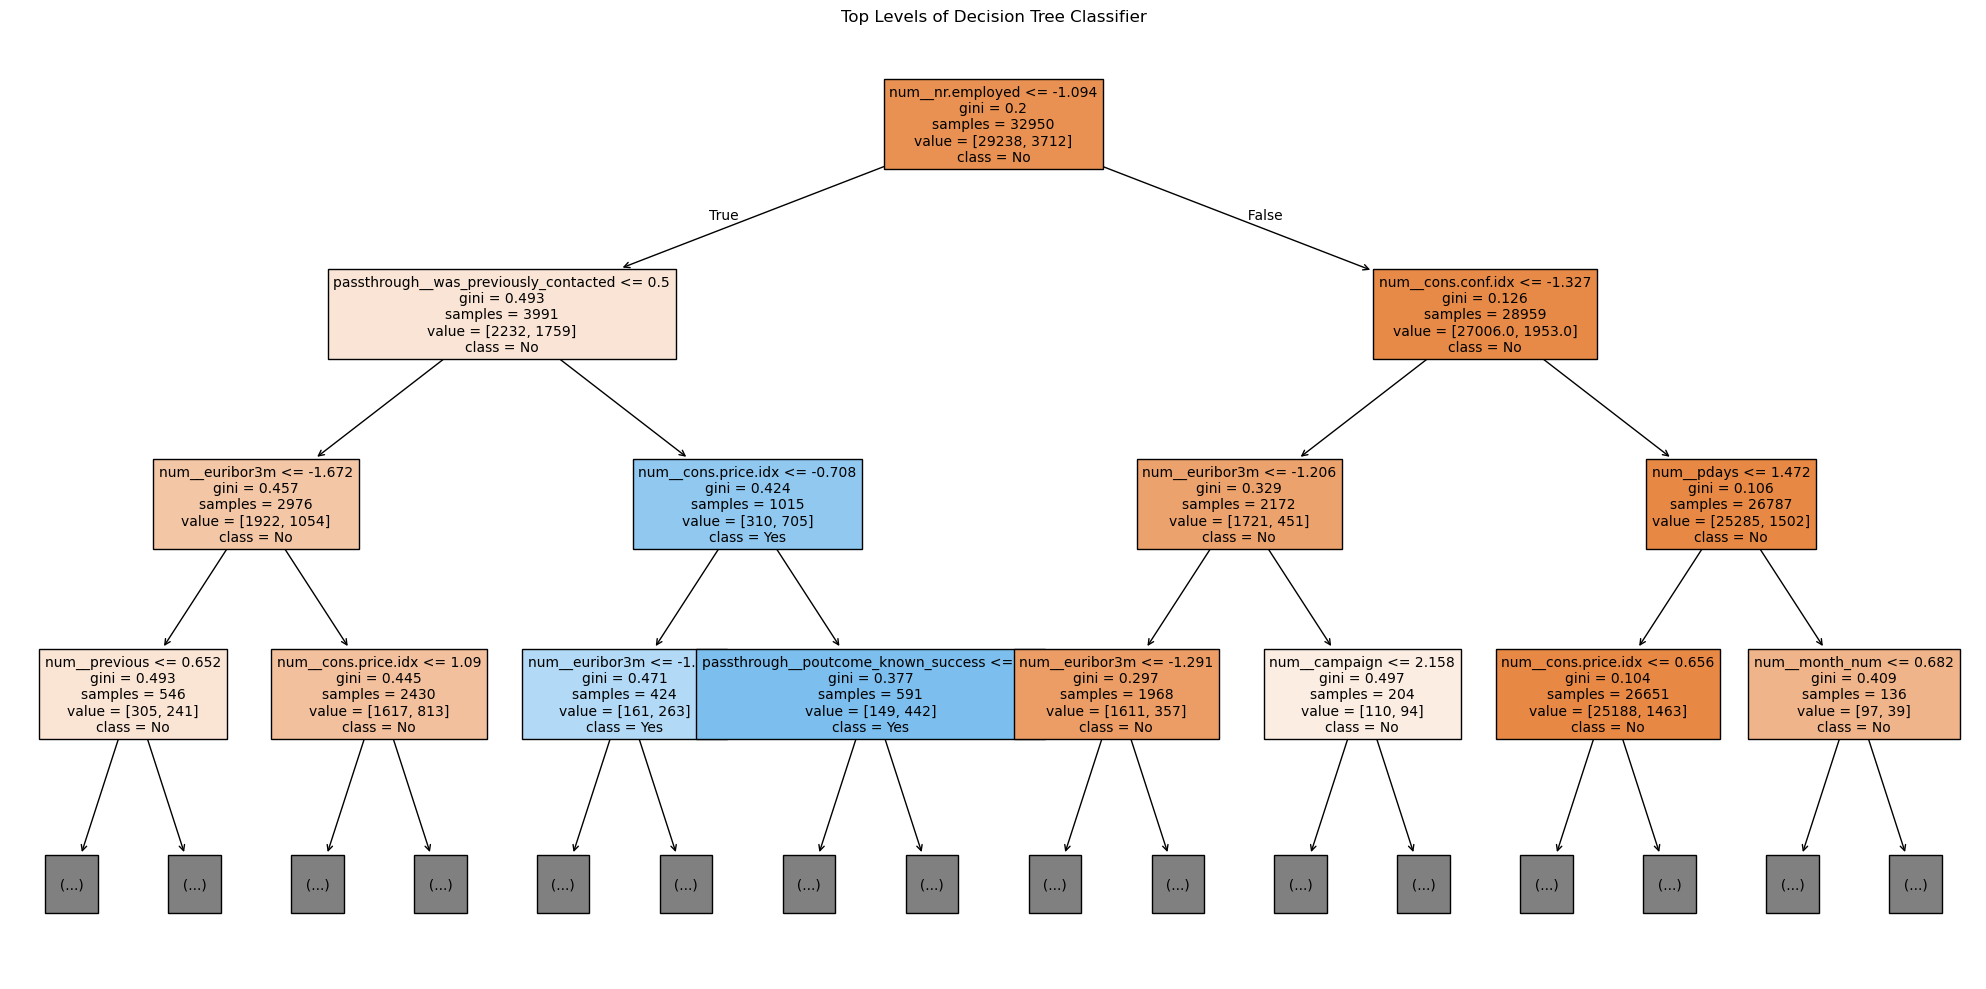

In [ ]:
# Get feature names after preprocessing
feature_names = tree_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extract the fitted Decision Tree
tree_model = tree_pipeline.named_steps['classifier']

# Plot the tree (truncated version to keep it readable)
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model,
    feature_names=feature_names,
    class_names=["No", "Yes"],
    filled=True,
    max_depth=3,  # Limit depth for readability
    fontsize=10
)
plt.title("Top Levels of Decision Tree Classifier")
plt.tight_layout()
plt.savefig("images/decision_tree_top_levels.png", dpi=300)
plt.show()


---

##  KNN vs. Logistic Regression

While Logistic Regression is highly interpretable (something that is important in this use case in advising the marketing team), switching to KNN nearly **doubles recall** for positive cases — but also more than **triples the false positives**, meaning significantly more outreach cost. To determine whether this tradeoff is worth it, we calculate the **minimum margin (profit) per new subscriber** needed to break even.


####  Confusion Matrix Comparison

| Model                | True Positives (TP) | False Positives (FP) |
|---------------------|---------------------|-----------------------|
| Logistic Regression | 172                 | 69                    |
| KNN                 | 279                 | 228                   |

- **Additional subscribers (TP)**: 279 − 172 = **+107**
- **Additional cost (FP)**: 228 − 69 = **+159**
  

### Interpreting the Cost of False Positives

Although the **K-Nearest Neighbors (KNN)** model predicts more clients will subscribe to a term deposit, it does so at the cost of contacting **more people who ultimately don’t convert** — known as **false positives (FPs)**.

This has real costs:
- Increased marketing spend
- Risk of frustrating uninterested clients

### Break-Even Analysis of Increased Marketing Spend

Let:

- **M** = required profit per subscriber (true positive)
- **C** = cost per campaign contact (outreach)

To break even:

> 107 × M ≥ 159 × C  
> ⇒ M ≥ (159 / 107) × C ≈ **1.49 × C**

**The margin per new subscriber must be at least 1.49× the cost per campaign contact.**

#### Example

If outreach cost **C = $2.00**, then:

> M ≥ 1.49 × 2 = **$2.98**

So for this example, each new subscriber would need to generate **at least $2.98 in profit** to justify using **KNN** over **Logistic Regression**.

---

### False Positives Might Still Be Valuable - even at the cost of frustrating currently uninterested clients

Interestingly, the **Logistic Regression model** identified **`was_previously_contacted`** as one of the **strongest positive predictors** of success. 

- A coefficient of **+1.3** implies the odds of a "yes" increase by a factor of:  **e ^1.3 ≈ 3.67**
  

> Clients who have been contacted before are **3.7x more likely** to subscribe in the future.

This suggests that even if a client doesn’t convert today, a contact attempt may **increase the chance of conversion in future campaigns** and builds the pool of prospects.

---

### Smart Targeting vs. Full Blast Tradeoff



Using model-driven targeting would have reduced outreach dramatically compared to a full campaign blast:

| Strategy                        | Contacts Sent | Subscriptions Captured | Subscriptions Missed |
|---------------------------------|----------------|--------------------------|-----------------------|
| **Full Blast**                  | 8238           | 928 (all subscribers)    | 0                     |
| **KNN Targeting**               | 507            | 279                      | 649                   |
| **Logistic Regression Targeting** | 241            | 172                      | 756                   |

- **KNN** reduces outreach by over 90% while capturing 30% of total conversions. Acceptance rate is 55% (279 / 507).
- **Logistic Regression** targets even fewer clients while still capturing 19% of conversions. Acceptance rate is 71% (172 / 241).

#### Strategic Insight

While the **KNN model** significantly reduces contact volume, it comes at the cost of **missed conversions**. **Logistic Regression**, though slightly less effective in recall, performs well with fewer outreach attempts and offers the benefit of **clear interpretability**.

Moreover, model coefficients highlight **previous contact as a strong indicator** of future conversion. This suggests that even contacts who don’t subscribe today may be more likely to convert in future campaigns — making **false positives less costly** in the long term.

> For ROI optimization, the business may consider a hybrid approach:  
> Use high-confidence targeting (like KNN) when resources are tight, and leverage Logistic Regression rankings when flexibility allows for broader, data-informed outreach.


##### Questions

Could a Random Forest model help us improve recall (move FN -> TP) to better capture and address the opportunity cost of missing customers while still helping us better target for marketing efficiency?